# Iceberg Image Detection

To avoid another disaster similar to Titanic, we want to create a model that is able to predict from satellite images if an object is an iceberg or a ship.

We use a dataset of satellite images, our goal is to understand it and create a model using this dataset to be able to predict from a given satellite image if it corresponds to a ship or an iceberg. Using these predictions we would know the areas to avoid when traveling by sea.


## 1) Data acquisition
We load the data from its location and explore it :

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the data
df_train = pd.read_json('data/iceberg/train.json')

In [12]:
# Checking some train data examples
df_train.head() 
#is_iceberg = variable cible qu'on veut predire ( 0 pour bateau et 1 pour iceberg)

id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   
1  e25388fd  [-12.242375, -14.920304999999999, -14.920363, ...   
2  58b2aaa0  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  4cfc3a18  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  271f93f4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...   38.1562           0  
2  [-24.870956, -24.092632, -20.653963, -19.41104...   45.2859           1  
3  [-27.889421, -27.519794, -27.165262, -29.10350...   43.8306           0  
4  [-27.206915, -30.259186, -30.259186, -23.16495...   35.6256           0

In [13]:
df_train.info()
# on a 1604 partout donc on a pas de valeur nulle

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


## 2) Data preparation
We load the data from its location and explore it :
### 2.1) Variables Signification
<ul>
<li>id - the id of the image</li>
<li>band_1, band_2 - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). More background on the satellite imagery can be found here.</li>
<li>inc_angle - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.</li>
<li>is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.</li>
</ul>

### 2.2) Missing data
Let us check for the presence of <b>na</b> values in the <i>inc_angle</i> variable

In [14]:
len(df_train[df_train['inc_angle']=='na'])
#nbre de valeur nulle

133

In [15]:
# We replace the 'na' string values with nan values so it can be easily handled
df_train['inc_angle'].replace('na',np.nan, inplace = True)
# on supprime na et on met null et on reprend info on voit maintenant qu'il y a 1604-1471 val manquante

In [16]:
# Now the df info shows that there are null values in inc_angle which was not visible before
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1604 non-null   object 
 1   band_1      1604 non-null   object 
 2   band_2      1604 non-null   object 
 3   inc_angle   1471 non-null   float64
 4   is_iceberg  1604 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 62.8+ KB


In [17]:
# on va remplacer les valeurs manquantes par la moyenne de l'ense
df_train['inc_angle'] = df_train['inc_angle'].replace('na',np.nan)

# Let's drop the NaN values.
trainData_noNaN = df_train.dropna()

# From the noNaN dataset, let's get the mean and standard deviation.
incAngleTrain_noNaN = np.array(trainData_noNaN['inc_angle'], dtype=float)
incAngleMean = incAngleTrain_noNaN.mean(dtype=np.float64)
incAngleStd = incAngleTrain_noNaN.std(dtype=np.float64)

# Using the mean and standard deviation, normalize the inclination angle to zero mean and standard deviation of 1.
df_train['inc_angle'] -= incAngleMean
df_train['inc_angle'] /= incAngleStd

# Replace the NaN values with the mean value, 0.0
df_train['inc_angle'] = df_train['inc_angle'].replace(np.nan, 0.0)

incAngleTrain = df_train['inc_angle']

### 2.3) Exploratory Data analysis
Do we really need two variables (band 1 & 2)?
Let us check their distribution :

C:\Users\esir\AppData\Local\Temp\ipykernel_12840\2737913329.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(totalBand1, label='Band 1')
C:\Users\esir\AppData\Local\Temp\ipykernel_12840\2737913329.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(totalBand2, label='Band 2')


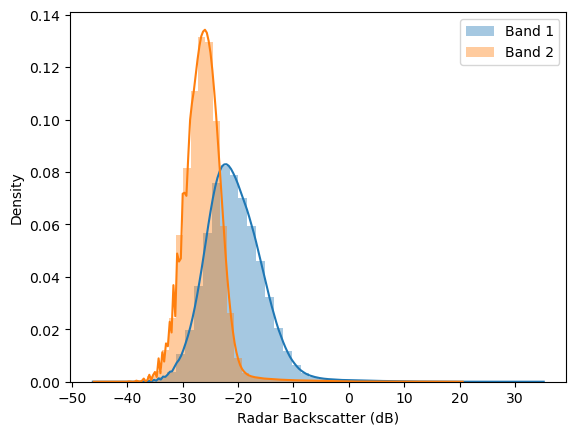

In [18]:
totalBand1 = []
totalBand2 = []
for imageVector in df_train['band_1']:
    for dB in imageVector:
        totalBand1.append(dB)
for imageVector in df_train['band_2']:
    for dB in imageVector:
        totalBand2.append(dB)
sns.distplot(totalBand1, label='Band 1')
sns.distplot(totalBand2, label='Band 2')
plt.legend()
plt.autoscale()
plt.xlabel('Radar Backscatter (dB)')
plt.ylabel('Density')
plt.savefig('Radar Backscatter Distribution.jpg')
plt.show()

# le resultat mon qu'on a pas les meme distribution qu'on elles semblent interessante pour notre etude

### 2.4) Image visualisation :
Since the band 1 & 2 are images, let us plot them alongside their labels

Given the distribution visualised, should we keep both variables? Why?

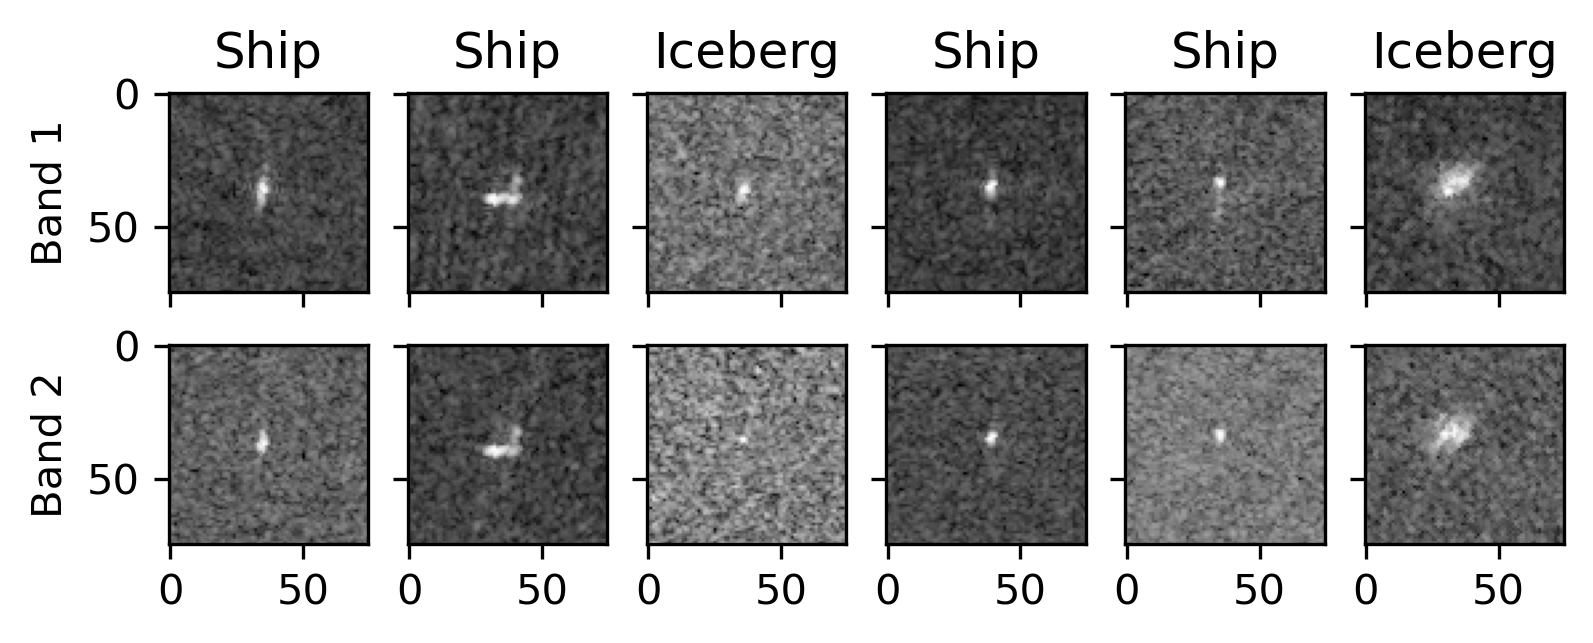

In [19]:
f, axarr = plt.subplots(nrows=2, ncols=6, sharex=True, sharey=True, figsize=(6,2), dpi=300)
for img in range (6):
    axarr[0, img].imshow(np.array(df_train['band_1'][img]).reshape((75,75)),cmap='binary_r')
    if df_train['is_iceberg'][img]==0:
        axarr[0, img].set_title('Ship')
    else:
        axarr[0, img].set_title('Iceberg')
    axarr[1, img].imshow(np.array(df_train['band_2'][img]).reshape((75,75)),cmap='binary_r')
axarr[0, 0].set_ylabel('Band 1')
axarr[1, 0].set_ylabel('Band 2')
plt.savefig('radar.jpg')
plt.show()

### 2.5) Data splitting and preparation :
We need to split our data into two sets : training and validation

We also need to reshape and normalize the images 

In [24]:
# afaire creer le train ( x_train 
from sklearn.model_selection import train_test_split

# TO-DO :
#   - Separate the target from the features
#   - Split the data into train and validation
Y_train = df_train['is_iceberg']
X_train = df_train.drop(['id','is_iceberg'],axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, random_state=1, train_size=0.8)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(1283, 3) (1283,)
(321, 3) (321,)


In [25]:
# Function used to reshape and normalize

def reshape_normalize(band):
    radarImage = np.empty([1,75,75,1])
    for vector in band:
        bandMatrix = np.array(vector).reshape((75, 75))
        bandMatrix = (bandMatrix - bandMatrix.min()) / (bandMatrix.max() - bandMatrix.min())
        bandMatrix = np.expand_dims(bandMatrix, axis=0)
        bandMatrix = np.expand_dims(bandMatrix, axis=-1)
        radarImage = np.concatenate((radarImage, bandMatrix))
    radarImage = np.delete(radarImage, 0, 0)
    return radarImage

In [26]:
band_1_train = reshape_normalize(X_train['band_1'])
band_2_train = reshape_normalize(X_train['band_2'])
angle_train = X_train['inc_angle']

## 3) Model creation :
Now that our data is ready, we need to create our model.

Unlike the sequential models that we have seen before, this time we will create a non-sequential model. This model has three separate branches that are later merged :

<ol>
<li>Convolutional Model for the first band</li>
<li>Convolutional Model for the second band</li>
<li>Input layer for the inc_angle</li>
</ol>

These three 'models' are then merged and fed to a Fully Connected Neural Network (Dense)

In [21]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras import optimizers
from keras import regularizers

# Define the input layers
band1 = Input(shape=(75, 75, 1))
band2 = Input(shape=(75, 75, 1))
angle = Input(shape=(1))

# Convolutional Model 1 for Band 1 Data
conv1 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='elu', input_shape=(75, 75, 1))(band1)
conv1 = MaxPooling2D(pool_size=2)(conv1)
conv1 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu')(conv1)
conv1 = GlobalAveragePooling2D()(conv1)

# Convolutional Model 2 for Band 2 Data
conv2 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='elu', input_shape=(75, 75, 1))(band2)
conv2 = MaxPooling2D(pool_size=2)(conv2)
conv2 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu')(conv2)
conv2 = GlobalAveragePooling2D()(conv2)

# Combine the convolution models' outputs as well as the inc_angle
merge = keras.layers.concatenate([conv1, conv2, angle])

# MLP to weigh the three inputs
mlp = Dense(500, activation='elu')(merge)
mlp = Dropout(0.5)(mlp)  # Add dropout for regularization
mlp = Dense(100, activation='elu')(mlp)
mlp = Dropout(0.5)(mlp)  # Add dropout for regularization

# Output layer
output = Dense(1, activation='sigmoid')(mlp)

# Create the model
model = Model(inputs=[band1, band2, angle], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 64)           1664      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 75, 75, 64)           1664      ['input_2[0][0]']             
                                                                                              

In [38]:
#Train the model : utilise plus de epochs = 200 pour avoir un modele capable de faire de bonne prediction
# pour des raisons de temps d'execution je me suis limité a epochs =20.

model.fit(x=[band_1_train, band_2_train, angle_train], y=Y_train, epochs=20, verbose=1)


Epoch 1/20
41/41 [==============================] - 88s 2s/step - loss: 0.6044 - accuracy: 0.6610
Epoch 2/20
41/41 [==============================] - 85s 2s/step - loss: 0.6046 - accuracy: 0.6680
Epoch 3/20
41/41 [==============================] - 84s 2s/step - loss: 0.6292 - accuracy: 0.6290
Epoch 4/20
41/41 [==============================] - 83s 2s/step - loss: 0.5968 - accuracy: 0.6571
Epoch 5/20
41/41 [==============================] - 86s 2s/step - loss: 0.6012 - accuracy: 0.6742
Epoch 6/20
41/41 [==============================] - 85s 2s/step - loss: 0.6034 - accuracy: 0.6610
Epoch 7/20
41/41 [==============================] - 84s 2s/step - loss: 0.5915 - accuracy: 0.6617
Epoch 8/20
41/41 [==============================] - 85s 2s/step - loss: 0.5934 - accuracy: 0.6734
Epoch 9/20
41/41 [==============================] - 91s 2s/step - loss: 0.5864 - accuracy: 0.6742
Epoch 10/20
41/41 [==============================] - 86s 2s/step - loss: 0.5976 - accuracy: 0.6610
Epoch 11/20
41/41 [

In [39]:
# Prepare the data for the validation set
band_1_test = reshape_normalize(X_valid['band_1'])
band_2_test = reshape_normalize(X_valid['band_2'])
angle_test = X_valid['inc_angle']

In [40]:
# Evaluate your model
#Specify the parameters for this function

labels_test = Y_valid  # Assuming y_valid contains the labels for the validation set

score = model.evaluate([band_1_test, band_2_test, angle_test], labels_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


11/11 [==============================] - 6s 536ms/step - loss: 0.5778 - accuracy: 0.6885
Test loss: 0.577785074710846
Test accuracy: 0.6884735226631165


In [ ]:
# avec le nombre d'epoque a 10 sur les données de test :
#11/11 [==============================] - 6s 538ms/step - loss: 0.5997 - accuracy: 0.6822
#Test loss: 0.5997408032417297
#Test accuracy: 0.6822429895401001
#accuracy: 0.6822

# avec le nombre d'epoque a 20 :

#11/11 [==============================] - 6s 536ms/step - loss: 0.5778
#Test loss: 0.577785074710846
#Test accuracy: 0.6884735226631165
#accuracy: 0.6885